<div style="text-align: center">
    <div style="font-size: xxx-large ; font-weight: 900 ; color: rgba(0 , 0 , 0 , 0.8) ; line-height: 100%">
        Signal Processing
    </div>
    <div style="font-size: x-large ; padding-top: 20px ; color: rgba(0 , 0 , 0 , 0.5)">
        Filtering Basics
    </div>
</div>

In [1]:
# Cell 0 - Preparation: load packages, set some basic options  
%matplotlib inline
import obspy
from obspy.clients.fdsn import Client
import numpy as np
import matplotlib.pylab as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 15, 4
plt.rcParams['lines.linewidth'] = 0.5

## The filter theory

A good definition of what a filter is can be found in the book 'Of poles and zeros' by Frank Scherbaum:

> _Filters or systems are, in the most general sense, devices (in the physical world) or algorithms (in the mathematical world) which act on some input signal to produce a - possibly different - output signal_

Use in seismology:
- correct for the instrument response
- avoid aliasing effects
- separate 'wanted' from 'unwanted' frequencies
- identify harmonic signals
- model a specific recording instrument
- ...   

There is no clear classification of filters. Roughly speaking, we can distinguish:
- linear vs. non-linear
- analog (circuits, resistors, conductors) vs. digital (logical components)
- continuous vs. discrete filters

Brief overview of filter terminology & definitions:
- **non-linear filters**: output contains frequencies which are not in input => avoided in seismology  
- **analog filters**: continuous or discrete
- **digital filters**: always discrete
- **discrete filters**: subdivided into infinite impulse response (IIR) filters & finite impulse response (FIR) filters
- **infinite impulse response (IIR) filters**: recursive & causal
- **finite impulse response (FIR) filters**: non-recursive & causal or acausal
- **causal filter**: output depends on past & present input, not symmetric
- **acausal filter**: output depends on past, present & future input, always symmetric
- **Recursive**: filter that re-uses one or more of its outputs as an input, feedback results in unending impulse response IIR that has exponentially growing, decaying or sinusoidal signal output components. 
- **Non-Recursive**: finite number of coefficients in the impulse response FIR, only uses input like x, no output used as input

In seismology, we generally avoid non-linear filters, because their output contains frequencies which are not in the input signal. 

Some filters have a special name, such as Butterworth, Chebyshev or Bessel filters, but they can also be integrated in the classification described above.

A filter is characterised by its **frequency response function** which is the [Fourier transformation](fourier_transform.ipynb) of the output signal divided by the Fourier transformation of the input signal:

$$ T(j\omega) = \frac{Y(j\omega)}{X(j\omega)}$$

For a simple lowpass filter it is given as:

$$ |T(j\omega)| = \sqrt{ \frac{1}{1+(\frac{\omega}{\omega_c})^{2n}} } $$

where
- $\omega$ = frequency samples
- $\omega_c$ = corner frequency of the filter 
- $n$ = order of the filter (also called the number of corners of the filter)

4 properties of a filter:
- **pass band**: range of frequencies below the corner frequency that are allowed to pass the filter for a **lowpass filter**
- **stop band**: range of frequencies above the corner frequency that are not allowed to pass the filter for a **lowpass filter**
- **transition band**: range of frequencies between pass band and stop band, a small band of frequencies in which the passed amplitudes are gradually decreased to zero 
- **order of the filter**: defines the steepness of the slope of this **transition band**: the higher the order, the steeper the slope, the more effectively 'unwanted' frequencies get removed. 

Meaning of filtering:
- In the time domain: 
    - to [convolve](convolution.ipynb) the data with the *impulse response function* of the filter
    - mathematically complex
    - computationally expensive
    - slow
- In the frequency domain:
    - used for most digital application of filters 
    - simplifies to a multiplication between data and filter response
    - faster
    - How to: transfer the signal into the frequency domain via FFT, multiply it with the filter's **frequency response function** (i.e. the FFT of the **impulse response function**), and transfer the result back to the time-domain. 

As a consequence, when filtering, we have to be aware of the characteristics and pit-falls of the [Fourier transformation](fourier_transform.ipynb).

---
### Filter types exercise

There are 4 main types of filters: 
- **lowpass filter**: one corner frequency, frequencies below this corner frequency pass the filter
- **highpass filter**: one corner frequency, frequencies above this corner frequency pass the filter
- **bandpass filter**: two corner frequencies, defined frequency band passes
- **bandstop filter**: two corner frequencies, defined frequency band stops

Here, we want to see how exactly these filters act on the input signal. In Cell 1, the vertical component of the M$_w\,$9.1 Tohoku earthquake, recorded at Wettzell - Germany, is downloaded and [pre-processed](spectral_analysis+preprocessing.ipynb). In Cell 2, the four basic filters are applied to these data and plotted together with the filter functions and the resulting amplitude spectrum. 

**Quesiton**:

1. Look at the figure and explain what the different filters do.   

**Question**:

2. Change the order of the filter (i.e the number of corners). What happens and why?  

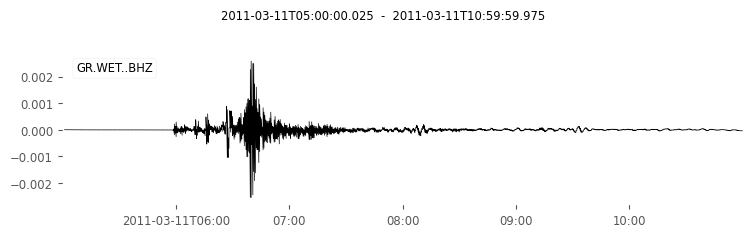

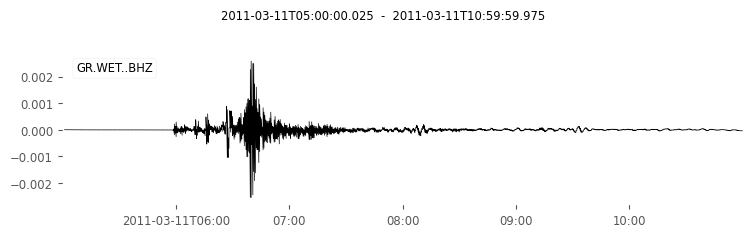

In [2]:
# Cell 1: prepare data from Tohoku earthquake. 
client = Client("BGR")
t1 = obspy.UTCDateTime("2011-03-11T05:00:00.000")
st = client.get_waveforms("GR", "WET", "", "BHZ", t1, t1 + 6 * 60 * 60, 
                          attach_response = True)
st.remove_response(output="VEL")
st.detrend('linear')
st.detrend('demean')
st.plot()

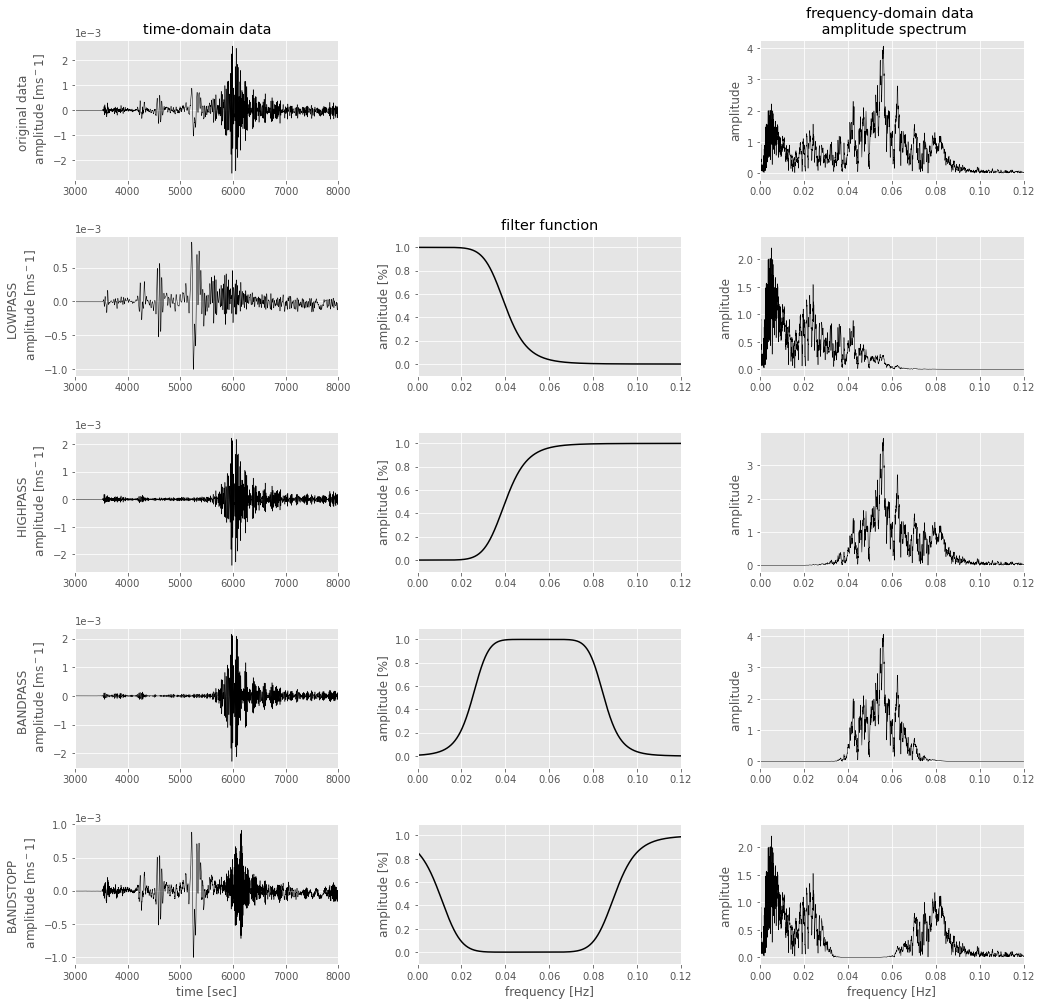

In [3]:
# Cell 2 - filter types
npts = st[0].stats.npts                   # number of samples in the trace
dt = st[0].stats.delta                    # sample interval
fNy = 1. / (2. * dt)                      # Nyquist frequency
time = np.arange(0, npts) * dt            # time axis for plotting
freq = np.linspace(0, fNy, npts // 2 + 1) # frequency axis for plotting
corners = 4                               # order of filter
# several filter frequencies for the different filter types
f0 = 0.04
fmin1 = 0.04
fmax1 = 0.07
fmin2 = 0.03
fmax2 = 0.07

# filter functions
LP = 1 / ( 1 + (freq / f0) ** (2 * corners))
HP = 1 - 1 / (1 + (freq / f0) ** (2 * corners))
wc = fmax1 - fmin1
wb = 0.5 * wc + fmin1
BP = 1/(1 + ((freq - wb) / wc) ** (2 * corners))
wc = fmax2 - fmin2
wb = 0.5 * wc + fmin2
BS = 1 - ( 1 / (1 + ((freq - wb) / wc) ** (2 * corners)))

# filtered traces
stHP = st.copy()
stHP.filter('highpass', freq=f0, corners=corners, zerophase=True)
stLP = st.copy()
stLP.filter('lowpass', freq=f0, corners=corners, zerophase=True)
stBP = st.copy()
stBP.filter('bandpass', freqmin=fmin1, freqmax=fmax1, corners=corners, zerophase=True)
stBS = st.copy()
stBS.filter('bandstop', freqmin=fmin2, freqmax=fmax2, corners=corners, zerophase=True)

# amplitude spectras
Ospec = np.fft.rfft(st[0].data)
LPspec = np.fft.rfft(stLP[0].data)
HPspec = np.fft.rfft(stHP[0].data)
BPspec = np.fft.rfft(stBP[0].data)
BSspec = np.fft.rfft(stBS[0].data)

# ---------------------------------------------------------------
# plot
plt.rcParams['figure.figsize'] = 17, 17
tx1 = 3000
tx2 = 8000
fx2 = 0.12

fig = plt.figure()

ax1 = fig.add_subplot(5,3,1)
ax1.ticklabel_format(style='sci', axis='y', scilimits=(-1,1))
plt.plot(time, st[0].data, 'k')
plt.xlim(tx1, tx2)
plt.title('time-domain data')
plt.ylabel('original data \n amplitude [ms$^-1$]')

ax3 = fig.add_subplot(5,3,3)
plt.plot(freq, abs(Ospec), 'k')
plt.title('frequency-domain data \n amplitude spectrum')
plt.ylabel('amplitude')
plt.xlim(0,fx2)

ax4 = fig.add_subplot(5,3,4)
ax4.ticklabel_format(style='sci', axis='y', scilimits=(-1,1))
plt.plot(time, stLP[0].data, 'k')
plt.xlim(tx1, tx2)
plt.ylabel('LOWPASS  \n amplitude [ms$^-1$]')

ax5 = fig.add_subplot(5,3,5)
plt.plot(freq, LP, 'k', linewidth=1.5)
plt.xlim(0,fx2)
plt.ylim(-0.1,1.1)
plt.title('filter function')
plt.ylabel('amplitude [%]')

ax6 = fig.add_subplot(5,3,6)
plt.plot(freq, abs(LPspec), 'k')
plt.ylabel('amplitude ')
plt.xlim(0,fx2)

ax7 = fig.add_subplot(5,3,7)
ax7.ticklabel_format(style='sci', axis='y', scilimits=(-1,1))
plt.plot(time, stHP[0].data, 'k')
plt.xlim(tx1, tx2)
plt.ylabel('HIGHPASS  \n amplitude [ms$^-1$]')

ax8 = fig.add_subplot(5,3,8)
plt.plot(freq, HP, 'k', linewidth=1.5)
plt.xlim(0,fx2)
plt.ylim(-0.1,1.1)
plt.ylabel('amplitude [%]')

ax9 = fig.add_subplot(5,3,9)
plt.plot(freq, abs(HPspec), 'k')
plt.ylabel('amplitude ')
plt.xlim(0,fx2)

ax10 = fig.add_subplot(5,3,10)
ax10.ticklabel_format(style='sci', axis='y', scilimits=(-1,1))
plt.plot(time, stBP[0].data, 'k')
plt.xlim(tx1, tx2)
plt.ylabel('BANDPASS  \n amplitude [ms$^-1$]')

ax11 = fig.add_subplot(5,3,11)
plt.plot(freq, BP, 'k', linewidth=1.5)
plt.xlim(0,fx2)
plt.ylim(-0.1,1.1)
plt.ylabel('amplitude [%]')

ax12 = fig.add_subplot(5,3,12)
plt.plot(freq, abs(BPspec), 'k')
plt.ylabel('amplitude ')
plt.xlim(0,fx2)

ax13 = fig.add_subplot(5,3,13)
ax13.ticklabel_format(style='sci', axis='y', scilimits=(-1,1))
plt.plot(time, stBS[0].data, 'k')
plt.xlim(tx1, tx2)
plt.xlabel('time [sec]')
plt.ylabel('BANDSTOPP \n amplitude [ms$^-1$]')

ax14 = fig.add_subplot(5,3,14)
plt.plot(freq, BS, 'k', linewidth=1.5)
plt.xlim(0,fx2)
plt.ylim(-0.1,1.1)
plt.ylabel('amplitude [%]')
plt.xlabel('frequency [Hz]')

ax15 = fig.add_subplot(5,3,15)
plt.plot(freq, abs(BSspec), 'k')
plt.xlabel('frequency [Hz]')
plt.ylabel('amplitude ')
plt.xlim(0,fx2)

plt.subplots_adjust(wspace=0.3, hspace=0.4)
plt.show()


---

### Causal versus acausal exercise

Filters can be causal or acausal. The output of a causal filter depends only on past and present input, while the output also depends on future input. Thus, an acausal filter is always symmetric and a causal one not. In this exercise, we want to see the effects of such filters on the signal. In Cell 3, the example seismogram of `ObsPy` is loaded and lowpass filtered several times with different filter order $n$ and causality.

**Question**:

3. Explain the effects of the different filters. You can also play with the order of the filter (variable $ncorners$).   

**Question**:

4. Zoom into a small window around the first onset (change the variables $start$, $end$ and $amp$). Which filter would you use for which purpose?

BW.RJOB..EHZ | 2009-08-24T00:20:03.000000Z - 2009-08-24T00:20:32.990000Z | 100.0 Hz, 3000 samples


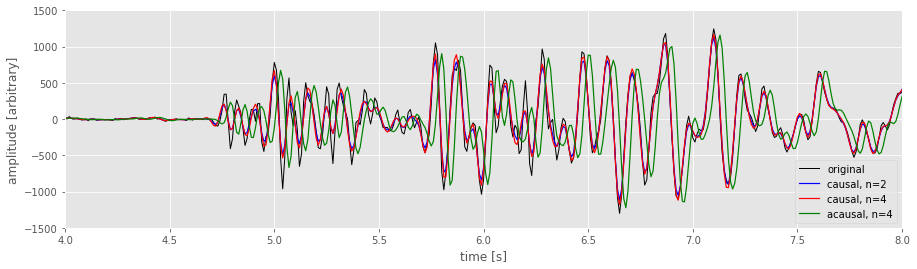

In [4]:
# Cell 3 - filter effects
stf = obspy.read()                   # load example seismogram
tr = stf[0]                    # select the first trace in the Stream object
tr.detrend('demean')           # preprocess data
tr.detrend('linear')
tr.filter("highpass", freq=2)  # removing long-period noise
print(tr)
t = tr.times()                 # time vector for x axis

f = 15.0                       # frequency for filters (intial: 10 Hz)
start = 4                      # start time to plot in sec (initial: 4)
end = 8                        # end time to plot in sec (initial: 8)
amp = 1500                     # amplitude range for plotting (initial: 1500)  
ncorners = 4                   # number of corners/order of the filter (initial: 4)

tr_filt = tr.copy()            # causal filter / not zero phase. Order = 2
tr_filt.filter('lowpass', freq=f, zerophase=True, corners=2)
tr_filt2 = tr.copy()           # causal filter / not zero phase. Order = set by ncorners
tr_filt2.filter('lowpass', freq=f, zerophase=True, corners=ncorners)
tr_filt3 = tr.copy()           # acausal filter / zero phase. Order = set by ncorners
tr_filt3.filter('lowpass', freq=f, zerophase=False, corners=ncorners)

# plot - comment single lines to better see the remaining ones
plt.rcParams['figure.figsize'] = 15, 4
plt.plot(t, tr.data, 'k', label='original', linewidth=1.)
plt.plot(t, tr_filt.data, 'b', label='causal, n=2', linewidth=1.2)
plt.plot(t, tr_filt2.data, 'r', label='causal, n=%s' % ncorners, linewidth=1.2)
plt.plot(t, tr_filt3.data, 'g', label='acausal, n=%s' % ncorners, linewidth=1.2)

plt.xlabel('time [s]')
plt.xlim(start, end)    
plt.ylim(-amp, amp)
plt.ylabel('amplitude [arbitrary]')
plt.legend(loc='lower right')

plt.show()

---
### Frequency ranges - bandpass filter exercise

We will now look at an event which took place in Kazakhstan on July 8, 1989. We want to see how filtering helps to derive information from a signal. The signal has been recorded by a Chinese station and is bandpassed in several different frequency bands.

**Question**:

5. What do you see in the different frequency bands?

**Question**:

6. Play with the channel used for filtering in Cell 5. What do you not see? Can you guess what kind of event it is?   

In [5]:
# Cell 4 - get + preprocess data
c = Client("IRIS")
tmp1 = obspy.UTCDateTime("1989-07-08T03:40:00.0")
tmp2 = obspy.UTCDateTime("1989-07-08T04:05:00.0")
dat = c.get_waveforms("CD", "WMQ", "", "BH*", tmp1, tmp2, attach_response = True)
dat.detrend('linear')
dat.detrend('demean')
dat.remove_response(output="VEL")
dat.detrend('linear')
dat.detrend('demean')
print(dat)
#dat.plot()

3 Trace(s) in Stream:
CD.WMQ..BHE | 1989-07-08T03:48:37.790000Z - 1989-07-08T04:04:41.040000Z | 20.0 Hz, 19266 samples
CD.WMQ..BHN | 1989-07-08T03:48:37.790000Z - 1989-07-08T04:04:41.040000Z | 20.0 Hz, 19266 samples
CD.WMQ..BHZ | 1989-07-08T03:48:37.790000Z - 1989-07-08T04:04:41.040000Z | 20.0 Hz, 19266 samples


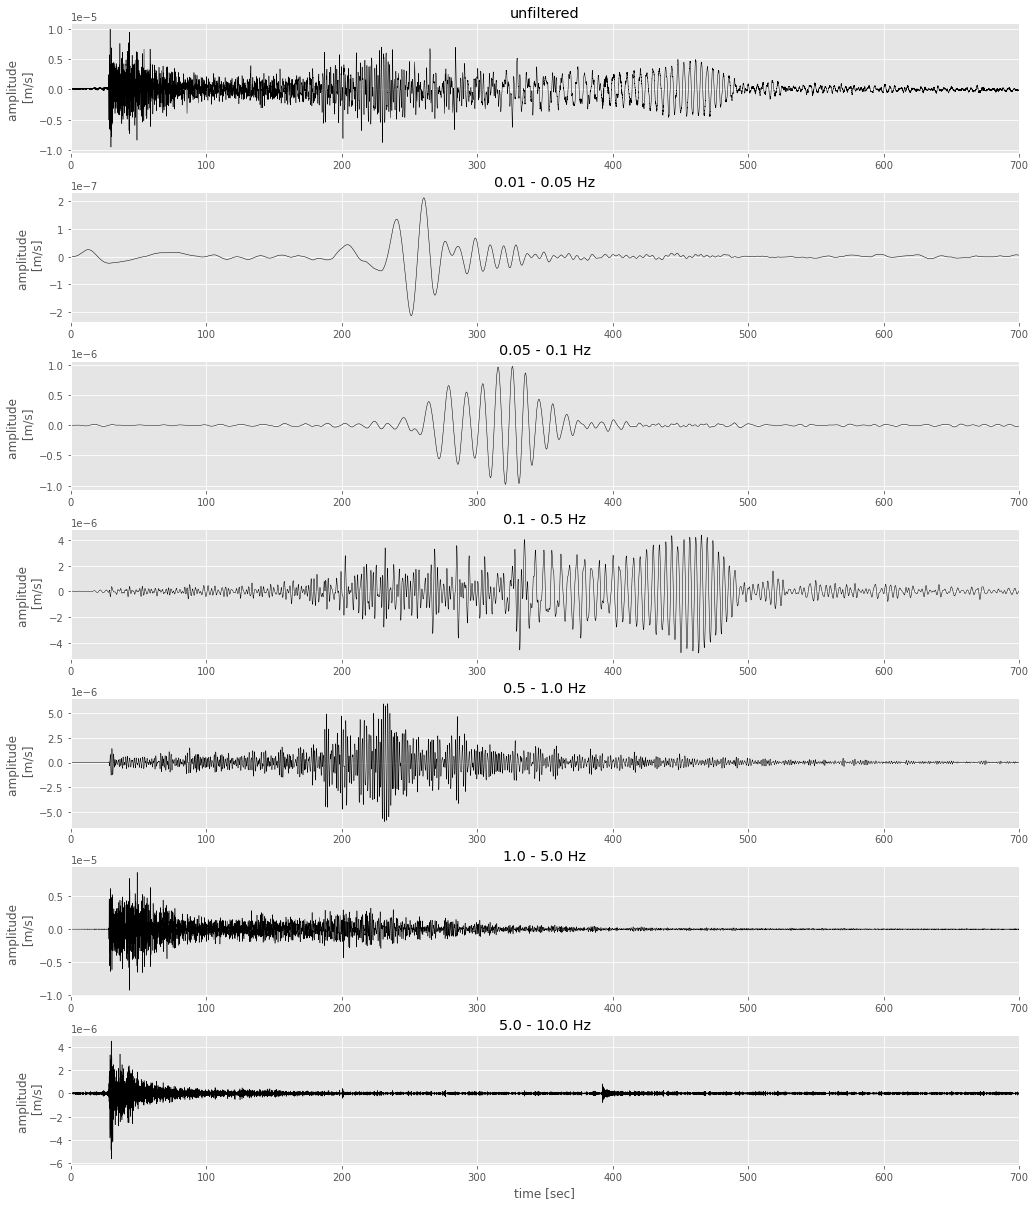

In [6]:
# Cell 5 - filter data in different frequency ranges

chanel = 2
tm = dat[chanel].times()
xmin = 0
xmax = 700

dat1 = dat[chanel].copy()
dat2 = dat[chanel].copy()
dat2.filter(type="bandpass", freqmin=0.01, freqmax=0.05)
dat3 = dat[chanel].copy()
dat3.filter(type="bandpass", freqmin=0.05, freqmax=0.1)
dat4 = dat[chanel].copy()
dat4.filter(type="bandpass", freqmin=0.1, freqmax=0.5)
dat5 = dat[chanel].copy()
dat5.filter(type="bandpass", freqmin=0.5, freqmax=1)
dat6 = dat[chanel].copy()
dat6.filter(type="bandpass", freqmin=1., freqmax=5.)
dat7 = dat[chanel].copy()
dat7.filter(type="bandpass", freqmin=5., freqmax=10.)

plt.rcParams['figure.figsize'] = 17, 21
fig = plt.figure()
ax1 = fig.add_subplot(7,1,1)
ax1.ticklabel_format(style='sci', axis='y', scilimits=(-1,1))
plt.plot(tm, dat1.data, 'k')
plt.xlim(xmin, xmax)
plt.title('unfiltered')
plt.ylabel('amplitude \n [m/s]')
ax2 = fig.add_subplot(7,1,2)
ax2.ticklabel_format(style='sci', axis='y', scilimits=(-1,1))
plt.plot(tm, dat2.data, 'k')
plt.xlim(xmin, xmax)
plt.title('0.01 - 0.05 Hz')
plt.ylabel('amplitude \n [m/s]')
ax3 = fig.add_subplot(7,1,3)
ax3.ticklabel_format(style='sci', axis='y', scilimits=(-1,1))
plt.plot(tm, dat3.data, 'k')
plt.xlim(xmin, xmax)
plt.title('0.05 - 0.1 Hz')
plt.ylabel('amplitude \n [m/s]')
ax4 = fig.add_subplot(7,1,4)
ax4.ticklabel_format(style='sci', axis='y', scilimits=(-1,1))
plt.plot(tm, dat4.data, 'k')
plt.xlim(xmin, xmax)
plt.title('0.1 - 0.5 Hz')
plt.ylabel('amplitude \n [m/s]')
ax5 = fig.add_subplot(7,1,5)
ax5.ticklabel_format(style='sci', axis='y', scilimits=(-1,1))
plt.plot(tm, dat5.data, 'k')
plt.xlim(xmin, xmax)
plt.title('0.5 - 1.0 Hz')
plt.ylabel('amplitude \n [m/s]')
ax6 = fig.add_subplot(7,1,6)
ax6.ticklabel_format(style='sci', axis='y', scilimits=(-1,1))
plt.plot(tm, dat6.data, 'k')
plt.xlim(xmin, xmax)
plt.title('1.0 - 5.0 Hz')
plt.ylabel('amplitude \n [m/s]')
ax7 = fig.add_subplot(7,1,7)
ax7.ticklabel_format(style='sci', axis='y', scilimits=(-1,1))
plt.plot(tm, dat7.data, 'k')
plt.xlim(xmin, xmax)
plt.title('5.0 - 10.0 Hz')
plt.xlabel('time [sec]')
plt.ylabel('amplitude \n [m/s]')
plt.subplots_adjust(hspace=0.3)
plt.show()

### Next lecture: [Theory - Spectral Analysis & Preprocessing](lecture_16_theory_spectral_analysis_preprocessing.ipynb)

---
##### Authors:
* Stefanie Donner ([@stefdonner](https://github.com/stefdonner))
* Celine Hadziioannou ([@hadzii](https://github.com/hadzii))
* Ceri Nunn ([@cerinunn](https://github.com/cerinunn))
* Eva Eibl ([@evaeibl](https://github.com/evaeibl))
* [Julian Niedermeier](https://github.com/sleighsoft)

Seismo-Live: http://seismo-live.org